In [2]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Visualization of pytorch architectures

## Pointnet

Loaded 1 point clouds from 40 classes
torch.Size([1, 4000, 3])


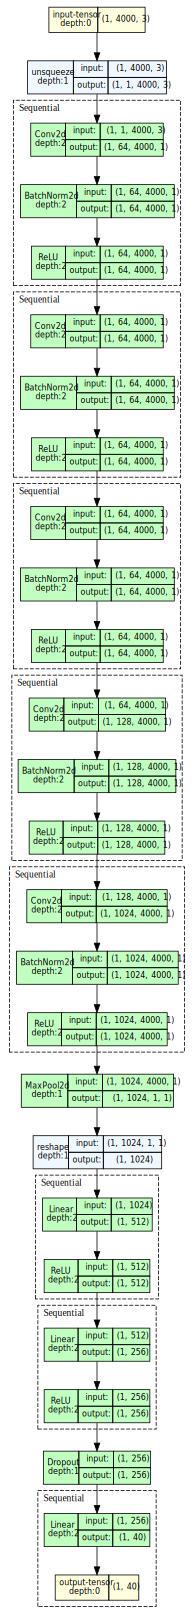

In [3]:
# in point net the unsqeeze is done in the network
import torchvision
from torchview import draw_graph
from networks.PointNet import PointNet
from dataset.PointCloudDataset import *

dataset_train  = PointCloudDataset('dataset/modelnet40_normal_resampled', 
                                            train=True, 
                                            ndata=1, 
                                            file_extension='.txt', 
                                            npoints=4000
                                        )

# torch tensor
data = dataset_train[0][0].unsqueeze(0)
print (data.shape)
model = PointNet(nclasses=40)

model_graph = draw_graph(model, input_size=data.shape, expand_nested=True)
model_graph.visual_graph

# Visualization of meshes from the ModelNet40 dataset

In [3]:
paths = ['dataset/ModelNet40/flower_pot/test/flower_pot_0152.off',
        'dataset/ModelNet40/car/test/car_0265.off',
        'dataset/ModelNet40/guitar/test/guitar_0157.off',
        'dataset/ModelNet40/bottle/test/bottle_0336.off']


for path in paths:
    mesh = o3d.io.read_triangle_mesh(path)
    mesh.compute_vertex_normals()
    mesh.paint_uniform_color([1, 0.706, 0])
    o3d.visualization.draw_geometries([mesh])


## Voxelization

show the same object with different voxelization resolutions

In [15]:
p = 'dataset/ModelNet40/flower_pot/test/flower_pot_0152.off'
mesh = o3d.io.read_triangle_mesh(p)

# set color
mesh.paint_uniform_color([1, 0.706, 0])

TriangleMesh with 6478 points and 4306 triangles.

In [ ]:

# voxelization
for vsize in [1,2,5]:
    voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=vsize)
    # create voxel grid with new grid
    o3d.visualization.draw_geometries([voxel_grid])

# Training history and results

## Pointnet

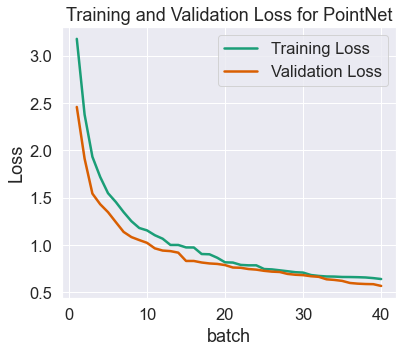

In [21]:
# visualize the training history

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", font_scale=1.5, palette = 'Dark2')

# load the data
train = np.load('checkpoints/pointnet/train_loss.npy')
val = np.load('checkpoints/pointnet/val_loss.npy')

# remove duplicates to fix a issue created in the saving, and avoid retraining
train = np.unique(train)
val = np.unique(val)
train = sorted(train, reverse=True)
val = sorted(val, reverse=True)

epochs = np.arange(1, len(train)+1)
lw = 2.5
# plot the data
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(epochs, train, label='Training Loss', lw=lw)
ax.plot(epochs, val, label='Validation Loss', lw=lw)

ax.set_title('Training and Validation Loss for PointNet')
ax.set_xlabel('batch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

# save the figure in pdf
fig.savefig('checkpoints/pointnet/loss_pointnet.pdf', bbox_inches='tight')

In [12]:
train

array([0.6385513 , 0.64820313, 0.65510005, 0.657999  , 0.65963316,
       0.66035664, 0.6645133 , 0.66571456, 0.67141944, 0.68106914,
       0.7067251 , 0.71079934, 0.7211362 , 0.73077404, 0.74043673,
       0.7444237 , 0.78342205, 0.7835545 , 0.7879773 , 0.8125561 ,
       0.8152545 , 0.8634201 , 0.90007406, 0.9029371 , 0.9718968 ,
       0.97267807, 0.9987055 , 0.9988145 , 1.0649151 , 1.1015437 ,
       1.1525168 , 1.1781055 , 1.2497679 , 1.3460044 , 1.4530501 ,
       1.545973  , 1.7172947 , 1.9308232 , 2.376953  , 3.1771924 ],
      dtype=float32)